In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

## Bonneville Dam Data Source

http://www.cbr.washington.edu/dart/query/adult_daily


In [2]:
# Create a list of dataframes to concat later
bonneville_salmon_list = []

# Loop through all the files and add them to the list
for i in range(8,21):
    
    # Read in Bonneville Dam Spring Chinook Counts
    bonneville_file = f"Resources/adultdaily_bonneville_20{i:02}.csv"
    
    # Grab only the columns we want
    bonneville_salmon_df = pd.read_csv(bonneville_file, usecols=["Project","Date","Chin"])
    
    # Append the df to the list
    bonneville_salmon_list.append(bonneville_salmon_df)

# Concat the list of dataframes    
combined_bonneville_salmon_df = pd.concat(bonneville_salmon_list)

# Clean up the na's with zero values
combined_bonneville_salmon_df["Chin"] = combined_bonneville_salmon_df["Chin"].fillna(0)

# Clean up data types
combined_bonneville_salmon_df["Chin"] = combined_bonneville_salmon_df["Chin"].astype('int')


combined_bonneville_salmon_df

,Project,Date,Chin
0,Bonneville,2008-03-01,0
1,Bonneville,2008-03-02,0
2,Bonneville,2008-03-03,1
3,Bonneville,2008-03-04,1
4,Bonneville,2008-03-05,0
...,...,...,...
87,Bonneville,2020-05-27,1238
88,Bonneville,2020-05-28,1016
89,Bonneville,2020-05-29,1485
90,Bonneville,2020-05-30,1309


In [3]:
yearly_bonneville_salmon_df = combined_bonneville_salmon_df.copy(deep=True)
yearly_bonneville_salmon_df[["Year", "Month", "Day"]] = yearly_bonneville_salmon_df['Date'].str.split('-', expand=True)
yearly_bonneville_salmon_df= yearly_bonneville_salmon_df.groupby("Year").agg({"Chin":"sum"}).reset_index()
yearly_bonneville_salmon_df["Year"] = yearly_bonneville_salmon_df["Year"].astype('int')
yearly_bonneville_salmon_df

,Year,Chin
0,2008,125582
1,2009,114548
2,2010,244419
3,2011,167132
4,2012,158088
5,2013,83339
6,2014,188079
7,2015,220471
8,2016,137204
9,2017,83623


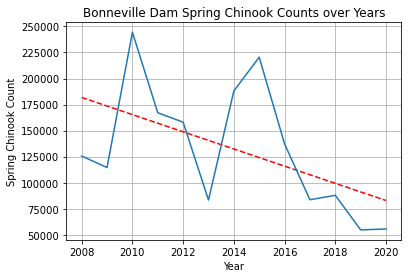

In [4]:
# Calculate a trend line
z = np.polyfit(yearly_bonneville_salmon_df["Year"], yearly_bonneville_salmon_df["Chin"], 1)
p = np.poly1d(z)

# Quick Plot of the Spring Chinook Counts over Years
fig, ax = plt.subplots()
ax.set_xlabel("Year")
ax.set_ylabel("Spring Chinook Count")
ax.set_title("Bonneville Dam Spring Chinook Counts over Years")
ax.grid(True)
ax.plot(yearly_bonneville_salmon_df["Year"],p(yearly_bonneville_salmon_df["Year"]),"r--")
ax.plot(yearly_bonneville_salmon_df["Year"], yearly_bonneville_salmon_df["Chin"] )

## Bonneville Above"Forebay" Data Source

https://waterdata.usgs.gov/usa/nwis/uv?site_no=453845121562000

mapper: https://maps.waterdata.usgs.gov/mapper/index.html

In [5]:
# Create bonneville above gage df
bonneville_above_temp_file = "Resources/Columbia_bonne_above.csv"
bonneville_above_temp_df = pd.read_csv(bonneville_above_temp_file, sep="\t")
bonneville_above_temp_df.head()

,agency_cd,site_no,datetime,Temp_Max,Status_Max_Temp,Temp_Min,Status_Temp_Min,Temp_Mean,Status_Temp_Mean
0,USGS,453845121562000,2008-02-28,5.2,A,4.9,A,5.0,A
1,USGS,453845121562000,2008-02-29,5.2,A,5.1,A,5.2,A
2,USGS,453845121562000,2008-03-01,5.3,A,5.2,A,5.2,A
3,USGS,453845121562000,2008-03-02,5.3,A,5.2,A,5.2,A
4,USGS,453845121562000,2008-03-03,5.3,A,5.2,A,5.2,A


In [6]:
# Clean the dataframe up and parse the dates
clean_bonneville_above_temp_df = bonneville_above_temp_df[["agency_cd", "site_no", "datetime", "Temp_Mean" ]].copy(deep=True)
clean_bonneville_above_temp_df = clean_bonneville_above_temp_df.rename(columns={"datetime":"Date"})
clean_bonneville_above_temp_df.head()

,agency_cd,site_no,Date,Temp_Mean
0,USGS,453845121562000,2008-02-28,5.0
1,USGS,453845121562000,2008-02-29,5.2
2,USGS,453845121562000,2008-03-01,5.2
3,USGS,453845121562000,2008-03-02,5.2
4,USGS,453845121562000,2008-03-03,5.2


In [7]:
# Check the types now
clean_bonneville_above_temp_df.dtypes

agency_cd     object
site_no        int64
Date          object
Temp_Mean    float64
dtype: object

In [8]:
# Merge Salmon Data with temp data
merged_above_bonneville_salmon_data_df = pd.merge(combined_bonneville_salmon_df, clean_bonneville_above_temp_df, on="Date")
merged_above_bonneville_salmon_data_df[merged_above_bonneville_salmon_data_df.isna().any(axis=1)]

# Create a Farenhieght Temperature
merged_above_bonneville_salmon_data_df['temperature_f'] = merged_above_bonneville_salmon_data_df['Temp_Mean'] * 1.8 + 32


In [9]:
clean_temp_df = merged_above_bonneville_salmon_data_df.dropna()
clean_temp_df[clean_temp_df.isna().any(axis=1)]

,Project,Date,Chin,agency_cd,site_no,Temp_Mean,temperature_f


In [10]:
clean_temp_df = clean_temp_df[
    clean_temp_df["Chin"] != 0
]
clean_temp_df

,Project,Date,Chin,agency_cd,site_no,Temp_Mean,temperature_f
2,Bonneville,2008-03-03,1,USGS,453845121562000,5.2,41.36
3,Bonneville,2008-03-04,1,USGS,453845121562000,5.2,41.36
5,Bonneville,2008-03-06,1,USGS,453845121562000,5.2,41.36
6,Bonneville,2008-03-07,1,USGS,453845121562000,5.2,41.36
7,Bonneville,2008-03-08,3,USGS,453845121562000,5.3,41.54
...,...,...,...,...,...,...,...
1191,Bonneville,2020-05-27,1238,USGS,453845121562000,13.5,56.30
1192,Bonneville,2020-05-28,1016,USGS,453845121562000,13.7,56.66
1193,Bonneville,2020-05-29,1485,USGS,453845121562000,14.0,57.20
1194,Bonneville,2020-05-30,1309,USGS,453845121562000,14.1,57.38


<BarContainer object of 970 artists>

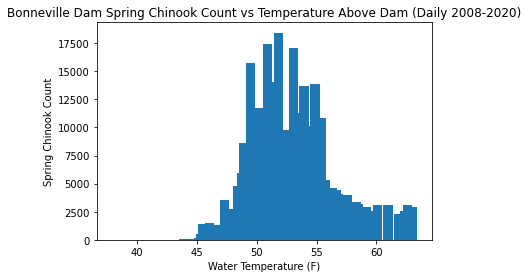

In [11]:
# Plot bar char distribution
fig, ax = plt.subplots()
ax.set_xlabel("Water Temperature (F)")
ax.set_ylabel("Spring Chinook Count")
ax.set_title("Bonneville Dam Spring Chinook Count vs Temperature Above Dam (Daily 2008-2020)")
ax.bar(clean_temp_df["temperature_f"], clean_temp_df["Chin"])

The r-value is: 0.3592601486635263
The r2-value is: 0.12906785441773902
The p-value is: 6.3521647965507195e-31


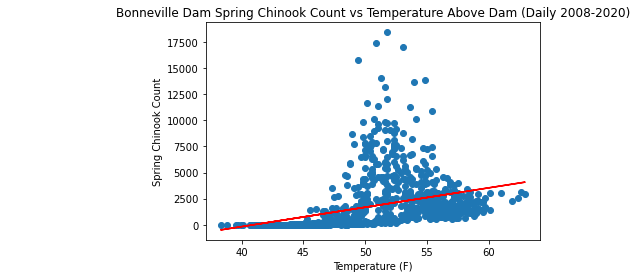

In [12]:
# Plot a scatter and regression of temperature and salmon counts to see if any correlation

slope, intercept, rvalue, pvalue, stderr = linregress(clean_temp_df["temperature_f"], 
                                                      clean_temp_df["Chin"])
regress_values =clean_temp_df["temperature_f"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-value is: {rvalue}")
print(f"The r2-value is: {rvalue**2}")
print(f"The p-value is: {pvalue}")

fig, ax = plt.subplots()
ax.set_xlabel("Temperature (F)")
ax.set_ylabel("Spring Chinook Count")
ax.set_title("Bonneville Dam Spring Chinook Count vs Temperature Above Dam (Daily 2008-2020)")
ax.annotate(line_eq, (21,14500), fontsize=15, color="red")
ax.plot(clean_temp_df["temperature_f"], regress_values, "r-")
ax.scatter(clean_temp_df["temperature_f"], clean_temp_df["Chin"])

# Above Bonneville "Stevensen" Gage Data Source
https://waterdata.usgs.gov/usa/nwis/uv?site_no=14128600

mapper: https://maps.waterdata.usgs.gov/mapper/index.html

In [13]:
# Get Stevensen gage data just above Bonneville
above_bonneville_stevenson_file = "Resources/columbia_bonne_stevenson.csv"
above_bonneville_stevenson_df = pd.read_csv(above_bonneville_stevenson_file, sep="\t")
above_bonneville_stevenson_df.head()

,agency_cd,site_no,datetime,Gage_Max,Status_Gage_Max,Gage_min,Status_gage_min,Gage_Mean,Status_Gage_Mean
0,USGS,14128600,2008-10-01,76.23,A,75.93,A,76.05,A
1,USGS,14128600,2008-10-02,76.33,A,76.03,A,76.21,A
2,USGS,14128600,2008-10-03,76.53,A,76.03,A,76.33,A
3,USGS,14128600,2008-10-04,76.33,A,76.03,A,76.11,A
4,USGS,14128600,2008-10-05,76.43,A,76.13,A,76.31,A


In [14]:
# Reduce data frame down to columns that I need
clean_above_bonneville_stevensen_gage_df = above_bonneville_stevenson_df[["agency_cd", "site_no", "datetime", "Gage_Mean" ]].copy(deep=True)
clean_above_bonneville_stevensen_gage_df.head()

,agency_cd,site_no,datetime,Gage_Mean
0,USGS,14128600,2008-10-01,76.05
1,USGS,14128600,2008-10-02,76.21
2,USGS,14128600,2008-10-03,76.33
3,USGS,14128600,2008-10-04,76.11
4,USGS,14128600,2008-10-05,76.31


In [15]:
# Clean the dataframe up and parse the dates
clean_above_bonneville_stevensen_gage_df = clean_above_bonneville_stevensen_gage_df[["agency_cd", "site_no", "datetime", "Gage_Mean" ]].copy(deep=True)
clean_above_bonneville_stevensen_gage_df = clean_above_bonneville_stevensen_gage_df.rename(columns={"datetime":"Date"})
clean_above_bonneville_stevensen_gage_df.head()

,agency_cd,site_no,Date,Gage_Mean
0,USGS,14128600,2008-10-01,76.05
1,USGS,14128600,2008-10-02,76.21
2,USGS,14128600,2008-10-03,76.33
3,USGS,14128600,2008-10-04,76.11
4,USGS,14128600,2008-10-05,76.31


In [16]:
# Check the types now
clean_above_bonneville_stevensen_gage_df.dtypes

agency_cd     object
site_no        int64
Date          object
Gage_Mean    float64
dtype: object

In [17]:
# Merge Salmon Data with Gage data
merged_above_bonneville_salmon_data_df = pd.merge(combined_bonneville_salmon_df, clean_above_bonneville_stevensen_gage_df, on="Date")
merged_above_bonneville_salmon_data_df[merged_above_bonneville_salmon_data_df.isna().any(axis=1)]

,Project,Date,Chin,agency_cd,site_no,Gage_Mean


<BarContainer object of 1104 artists>

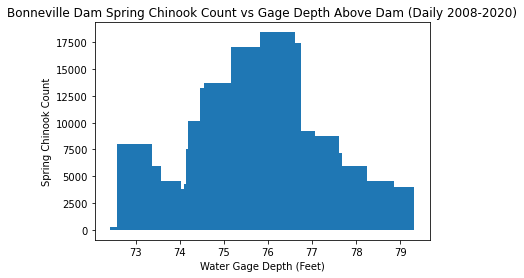

In [18]:
# Plot bar char distribution
fig, ax = plt.subplots()
ax.set_xlabel("Water Gage Depth (Feet)")
ax.set_ylabel("Spring Chinook Count")
ax.set_title("Bonneville Dam Spring Chinook Count vs Gage Depth Above Dam (Daily 2008-2020)")
ax.bar(merged_above_bonneville_salmon_data_df["Gage_Mean"], merged_above_bonneville_salmon_data_df["Chin"])

The r-value is: 0.1478259944818323
The r2-value is: 0.021852524644542716
The p-value is: 8.085071504614143e-07


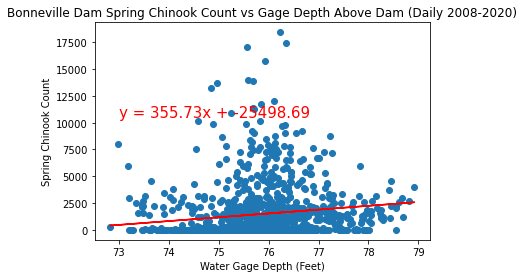

In [19]:
# Plot a scatter and regression of river depth and salmon counts to see if any correlation

slope, intercept, rvalue, pvalue, stderr = linregress(merged_above_bonneville_salmon_data_df["Gage_Mean"], 
                                                      merged_above_bonneville_salmon_data_df["Chin"])
regress_values =merged_above_bonneville_salmon_data_df["Gage_Mean"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-value is: {rvalue}")
print(f"The r2-value is: {rvalue**2}")
print(f"The p-value is: {pvalue}")

fig, ax = plt.subplots()
ax.set_xlabel("Water Gage Depth (Feet)")
ax.set_ylabel("Spring Chinook Count")
ax.set_title("Bonneville Dam Spring Chinook Count vs Gage Depth Above Dam (Daily 2008-2020)")
ax.annotate(line_eq, (73,10500), fontsize=15, color="red")
ax.plot(merged_above_bonneville_salmon_data_df["Gage_Mean"], regress_values, "r-")
ax.scatter(merged_above_bonneville_salmon_data_df["Gage_Mean"], merged_above_bonneville_salmon_data_df["Chin"])